# Predicting NFL Game Outcomes
## Rohan Lewis, Michael Nercessian, Matthew Armstrong

# 2019 NFL Game by Game Data

We first manually downloaded our data from this source: https://www.pro-football-reference.com/teams/

Our first step will be to import all of the modules we need, and then load the data.

In [1]:
# import Pkg
# Pkg.add("CSV")
# Pkg.add("Plots")
# Pkg.add("DataFrames")
# Pkg.add("Statistics")

In [243]:
using Random
using CSV
using Plots
using DataFrames
using Statistics
using Distributions
using StatsBase
using LowRankModels
using LinearAlgebra
include("proxgrad.jl")

proxgrad_const

In [3]:
nfl_teams = CSV.read("Datasets/nfl_teams.csv")
nfl_teams_with_spaces = CSV.read("Datasets/nfl_teams_with_spaces.csv")
showall(nfl_teams_with_spaces)

32×5 DataFrame
│ Row │ ID    │ Name                 │ Abbreviation │ Conference │ Division │
│     │ Int64 │ String               │ String       │ String     │ String   │
├─────┼───────┼──────────────────────┼──────────────┼────────────┼──────────┤
│ 1   │ 1     │ Arizona Cardinals    │ ARI          │ NFC        │ West     │
│ 2   │ 2     │ Atlanta Falcons      │ ATL          │ NFC        │ South    │
│ 3   │ 3     │ Baltimore Ravens     │ BAL          │ AFC        │ North    │
│ 4   │ 4     │ Buffalo Bills        │ BUF          │ AFC        │ East     │
│ 5   │ 5     │ Carolina Panthers    │ CAR          │ NFC        │ South    │
│ 6   │ 6     │ Chicago Bears        │ CHI          │ NFC        │ North    │
│ 7   │ 7     │ Cincinnati Bengals   │ CIN          │ AFC        │ North    │
│ 8   │ 8     │ Cleveland Browns     │ CLE          │ AFC        │ North    │
│ 9   │ 9     │ Dallas Cowboys       │ DAL          │ NFC        │ East     │
│ 10  │ 10    │ Denver Broncos       │ DEN       

In [4]:
abbreviations = [nfl_teams[:, 1] nfl_teams[:, 3]];

In [5]:
team_names = nfl_teams[:, 2]
team_names_split = String.(reduce(hcat,split.(team_names,' ')))
team_names_split = team_names_split[2, :]
team_names_split = [nfl_teams[:, 1] map(lowercase, team_names_split)];

In [6]:
# team_paths = []
# for i in 1:size(team_names_split,1)
#     team_names_split[i,2] = "Datasets/2019 Teams/" * team_names_split[i,2] * "_2019.csv"
# end
# team_names_split;

In [7]:
# original_teams = Array{DataFrame,1}(undef,32)
# for i in 1:32
#     original_teams[i] = CSV.read(team_names_split[i,2], header = 2)
# end

In [8]:
# teams = copy(original_teams);

In [9]:
# teams[1][:Column9][Not(ismissing.(teams[1][:Column9]))] .= "-1"
# teams[1][:Column9][ismissing.(teams[1][:Column9])] .= "1"
# parse.(Int64,teams[1][:Column9])

# teams[1][!,:Column9] = convert.(Int64,teams[1][!,:Column9])

In [10]:
nfl_final = CSV.read("Datasets/2002_thru_2019.csv", header = 2);

In [11]:
# showall(head(nfl_final[0:10,:])
# showall(nfl_final[50:70,:])

In [12]:
nfl_orig = copy(nfl_final)

,Unnamed: 0_level_1,Unnamed: 1_level_1,Week,Day,Date,Unnamed: 3_level_1
,Float64?,Float64?,String?,String?,String?,String?
1,2019.0,1.0,1,Sun,September 8,4:25PM ET
2,2019.0,1.0,2,Sun,September 15,1:00PM ET
3,2019.0,1.0,3,Sun,September 22,4:05PM ET
4,2019.0,1.0,4,Sun,September 29,4:05PM ET
5,2019.0,1.0,5,Sun,October 6,1:00PM ET
6,2019.0,1.0,6,Sun,October 13,4:05PM ET
7,2019.0,1.0,7,Sun,October 20,1:00PM ET
8,2019.0,1.0,8,Sun,October 27,1:00PM ET
9,2019.0,1.0,9,Thu,October 31,8:20PM ET


In [13]:
# nfl_final = copy(nfl_orig)

In [14]:
wks = collect(1:17)
wks = string.(wks)

#removes bye weeks/missing weeks
nfl_final = nfl_final[.!(ismissing.(nfl_final[!, :Week])), :]
nfl_final = nfl_final[.!(ismissing.(nfl_final[!, :Date])), :]

#removes playoff games
nfl_final = filter(row -> row[:Week] in wks, nfl_final)

#removes extraneous columns
nfl_final = nfl_final[:,1:24]
nfl_final = nfl_final[:, setdiff(1:end, (4,5,6,7,8,9))]

,Unnamed: 0_level_1,Unnamed: 1_level_1,Week,Rec,Unnamed: 8_level_1,Opp
,Float64?,Float64?,String?,String?,String?,String?
1,2019.0,1.0,1,0-0-1,missing,Detroit Lions
2,2019.0,1.0,2,0-1-1,@,Baltimore Ravens
3,2019.0,1.0,3,0-2-1,missing,Carolina Panthers
4,2019.0,1.0,4,0-3-1,missing,Seattle Seahawks
5,2019.0,1.0,5,1-3-1,@,Cincinnati Bengals
6,2019.0,1.0,6,2-3-1,missing,Atlanta Falcons
7,2019.0,1.0,7,3-3-1,@,New York Giants
8,2019.0,1.0,8,3-4-1,@,New Orleans Saints
9,2019.0,1.0,9,3-5-1,missing,San Francisco 49ers


In [15]:
rename!(nfl_final, Symbol("Unnamed: 1_level_1") => :Team)
rename!(nfl_final, Symbol("Unnamed: 0_level_1") => :Year)
rename!(nfl_final, Symbol("Unnamed: 8_level_1") => :isHome)
showall(nfl_final[1:10, :])

10×18 DataFrame
│ Row │ Year     │ Team     │ Week    │ Rec     │ isHome  │
│     │ Float64? │ Float64? │ String? │ String? │ String? │
├─────┼──────────┼──────────┼─────────┼─────────┼─────────┤
│ 1   │ 2019.0   │ 1.0      │ 1       │ 0-0-1   │ missing │
│ 2   │ 2019.0   │ 1.0      │ 2       │ 0-1-1   │ @       │
│ 3   │ 2019.0   │ 1.0      │ 3       │ 0-2-1   │ missing │
│ 4   │ 2019.0   │ 1.0      │ 4       │ 0-3-1   │ missing │
│ 5   │ 2019.0   │ 1.0      │ 5       │ 1-3-1   │ @       │
│ 6   │ 2019.0   │ 1.0      │ 6       │ 2-3-1   │ missing │
│ 7   │ 2019.0   │ 1.0      │ 7       │ 3-3-1   │ @       │
│ 8   │ 2019.0   │ 1.0      │ 8       │ 3-4-1   │ @       │
│ 9   │ 2019.0   │ 1.0      │ 9       │ 3-5-1   │ missing │
│ 10  │ 2019.0   │ 1.0      │ 10      │ 3-6-1   │ @       │

│ Row │ Opp                  │ Tm      │ Opp_1   │ 1stD    │ TotYd   │ PassY   │
│     │ String?              │ String? │ String? │ String? │ String? │ String? │
├─────┼──────────────────────┼─────────┼─

In [16]:
num = size(nfl_final)[1]
opps = zeros(num)

#     isHome = ones(16)
for k in 1:num
    opp = nfl_final[:Opp][k]
    idx = 0
    for j in 1:32
        if nfl_teams_with_spaces[:,2][j] == opp
            idx = j
        end
    end
    if idx == 0
        if opp == "San Diego Chargers"
            idx = 26
        end
        if opp == "St. Louis Rams"
            idx = 29
        end
    end
    opps[k] = idx
#     append!(opps, idx)
#         if ismissing(teams[i][:Column9][k])
#             isHome[i]*=-1
end
insertcols!(nfl_final, 3, :Opponent => opps)
nfl_final = select!(nfl_final, Not(:Opp))

,Year,Team,Opponent,Week,Rec,isHome,Tm,Opp_1,1stD
,Float64?,Float64?,Float64,String?,String?,String?,String?,String?,String?
1,2019.0,1.0,11.0,1,0-0-1,missing,27.0,27.0,21.0
2,2019.0,1.0,3.0,2,0-1-1,@,17.0,23.0,15.0
3,2019.0,1.0,5.0,3,0-2-1,missing,20.0,38.0,21.0
4,2019.0,1.0,28.0,4,0-3-1,missing,10.0,27.0,20.0
5,2019.0,1.0,7.0,5,1-3-1,@,26.0,23.0,26.0
6,2019.0,1.0,2.0,6,2-3-1,missing,34.0,33.0,24.0
7,2019.0,1.0,21.0,7,3-3-1,@,27.0,21.0,18.0
8,2019.0,1.0,20.0,8,3-4-1,@,9.0,31.0,10.0
9,2019.0,1.0,27.0,9,3-5-1,missing,25.0,28.0,19.0


In [17]:
showall(nfl_final[1:10,:])

10×18 DataFrame
│ Row │ Year     │ Team     │ Opponent │ Week    │ Rec     │ isHome  │ Tm      │
│     │ Float64? │ Float64? │ Float64  │ String? │ String? │ String? │ String? │
├─────┼──────────┼──────────┼──────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 2019.0   │ 1.0      │ 11.0     │ 1       │ 0-0-1   │ missing │ 27.0    │
│ 2   │ 2019.0   │ 1.0      │ 3.0      │ 2       │ 0-1-1   │ @       │ 17.0    │
│ 3   │ 2019.0   │ 1.0      │ 5.0      │ 3       │ 0-2-1   │ missing │ 20.0    │
│ 4   │ 2019.0   │ 1.0      │ 28.0     │ 4       │ 0-3-1   │ missing │ 10.0    │
│ 5   │ 2019.0   │ 1.0      │ 7.0      │ 5       │ 1-3-1   │ @       │ 26.0    │
│ 6   │ 2019.0   │ 1.0      │ 2.0      │ 6       │ 2-3-1   │ missing │ 34.0    │
│ 7   │ 2019.0   │ 1.0      │ 21.0     │ 7       │ 3-3-1   │ @       │ 27.0    │
│ 8   │ 2019.0   │ 1.0      │ 20.0     │ 8       │ 3-4-1   │ @       │ 9.0     │
│ 9   │ 2019.0   │ 1.0      │ 27.0     │ 9       │ 3-5-1   │ missing │ 25.0    │
│ 10  │ 2019

In [18]:
nfl_final[:isHome][Not(ismissing.(nfl_final[:isHome]))] .= "0"
nfl_final[:isHome][ismissing.(nfl_final[:isHome])] .= "1"
    
nfl_final[:TO][ismissing.(nfl_final[:TO])] .= "0"
nfl_final[:TO_1][ismissing.(nfl_final[:TO_1])] .= "0"

2087-element view(::Array{Union{Missing, String},1}, [2, 4, 5, 6, 9, 12, 16, 17, 19, 20  …  9162, 9163, 9165, 9186, 9189, 9196, 9202, 9209, 9212, 9213]) with eltype Union{Missing, String}:
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"
 ⋮
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"
 "0"

In [19]:
showall(nfl_final[1:10,:])

10×18 DataFrame
│ Row │ Year     │ Team     │ Opponent │ Week    │ Rec     │ isHome  │ Tm      │
│     │ Float64? │ Float64? │ Float64  │ String? │ String? │ String? │ String? │
├─────┼──────────┼──────────┼──────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 2019.0   │ 1.0      │ 11.0     │ 1       │ 0-0-1   │ 1       │ 27.0    │
│ 2   │ 2019.0   │ 1.0      │ 3.0      │ 2       │ 0-1-1   │ 0       │ 17.0    │
│ 3   │ 2019.0   │ 1.0      │ 5.0      │ 3       │ 0-2-1   │ 1       │ 20.0    │
│ 4   │ 2019.0   │ 1.0      │ 28.0     │ 4       │ 0-3-1   │ 1       │ 10.0    │
│ 5   │ 2019.0   │ 1.0      │ 7.0      │ 5       │ 1-3-1   │ 0       │ 26.0    │
│ 6   │ 2019.0   │ 1.0      │ 2.0      │ 6       │ 2-3-1   │ 1       │ 34.0    │
│ 7   │ 2019.0   │ 1.0      │ 21.0     │ 7       │ 3-3-1   │ 0       │ 27.0    │
│ 8   │ 2019.0   │ 1.0      │ 20.0     │ 8       │ 3-4-1   │ 0       │ 9.0     │
│ 9   │ 2019.0   │ 1.0      │ 27.0     │ 9       │ 3-5-1   │ 1       │ 25.0    │
│ 10  │ 2019

In [20]:
checkpoint = copy(nfl_final)

,Year,Team,Opponent,Week,Rec,isHome,Tm,Opp_1,1stD
,Float64?,Float64?,Float64,String?,String?,String?,String?,String?,String?
1,2019.0,1.0,11.0,1,0-0-1,1,27.0,27.0,21.0
2,2019.0,1.0,3.0,2,0-1-1,0,17.0,23.0,15.0
3,2019.0,1.0,5.0,3,0-2-1,1,20.0,38.0,21.0
4,2019.0,1.0,28.0,4,0-3-1,1,10.0,27.0,20.0
5,2019.0,1.0,7.0,5,1-3-1,0,26.0,23.0,26.0
6,2019.0,1.0,2.0,6,2-3-1,1,34.0,33.0,24.0
7,2019.0,1.0,21.0,7,3-3-1,0,27.0,21.0,18.0
8,2019.0,1.0,20.0,8,3-4-1,0,9.0,31.0,10.0
9,2019.0,1.0,27.0,9,3-5-1,1,25.0,28.0,19.0


In [21]:
# nfl_final = copy(checkpoint)

In [22]:
nfl_final[:Week] = [parse(Int,x) for x in nfl_final[:Week]]
nfl_final[:isHome] = [parse(Int,x) for x in nfl_final[:isHome]]
nfl_final = select!(nfl_final, Not(:Rec))

,Year,Team,Opponent,Week,isHome,Tm,Opp_1,1stD,TotYd
,Float64?,Float64?,Float64,Int64,Int64,String?,String?,String?,String?
1,2019.0,1.0,11.0,1,1,27.0,27.0,21.0,387.0
2,2019.0,1.0,3.0,2,0,17.0,23.0,15.0,349.0
3,2019.0,1.0,5.0,3,1,20.0,38.0,21.0,248.0
4,2019.0,1.0,28.0,4,1,10.0,27.0,20.0,321.0
5,2019.0,1.0,7.0,5,0,26.0,23.0,26.0,514.0
6,2019.0,1.0,2.0,6,1,34.0,33.0,24.0,442.0
7,2019.0,1.0,21.0,7,0,27.0,21.0,18.0,245.0
8,2019.0,1.0,20.0,8,0,9.0,31.0,10.0,237.0
9,2019.0,1.0,27.0,9,1,25.0,28.0,19.0,357.0


In [26]:
# nfl_final[:PassY] = [parse(Float64,x) for x in nfl_final[:PassY]]
# nfl_final[:Week] = [parse(Int,x) for x in nfl_final[:Tm]]
# nfl_final[:Week] = [parse(Int,x) for x in nfl_final[:Opp_1]]
# nm = names(nfl_final)
# for name in nm
#     if typeof(nfl_final[Symbol(name)][1]) == String
#         nfl_final[Symbol(name)] = [parse(Float64,x) for x in nfl_final[Symbol(name)]]
#     end
# end
# showall(nfl_final[1:10,:])

nm = names(nfl_final)
for name in nm
    for i in 1:num
        if ismissing(nfl_final[!, Symbol(name)][i])
            nfl_final[Symbol(name)][i] = "0.0"
            println(name)
            println("$i ")
        end
    end
end

In [48]:
for name in nm
    if typeof(nfl_final[Symbol(name)][1]) == Float64
        println(typeof(nfl_final[Symbol(name)]))
        #nfl_final[Symbol(name)] = [parse(Float64,x) for x in nfl_final[Symbol(name)]]
    end
end

Array{Union{Missing, Float64},1}
Array{Union{Missing, Float64},1}
Array{Float64,1}
Array{Float64,1}
Array{Float64,1}
Array{Float64,1}
Array{Float64,1}
Array{Float64,1}
Array{Float64,1}
Array{Float64,1}
Array{Float64,1}
Array{Float64,1}
Array{Float64,1}
Array{Float64,1}
Array{Float64,1}
10×17 DataFrame
│ Row │ Year     │ Team     │ Opponent │ Week  │ isHome │ Tm      │ Opp_1   │
│     │ Float64? │ Float64? │ Float64  │ Int64 │ Int64  │ Float64 │ Float64 │
├─────┼──────────┼──────────┼──────────┼───────┼────────┼─────────┼─────────┤
│ 1   │ 2019.0   │ 1.0      │ 11.0     │ 1     │ 1      │ 27.0    │ 27.0    │
│ 2   │ 2019.0   │ 1.0      │ 3.0      │ 2     │ 0      │ 17.0    │ 23.0    │
│ 3   │ 2019.0   │ 1.0      │ 5.0      │ 3     │ 1      │ 20.0    │ 38.0    │
│ 4   │ 2019.0   │ 1.0      │ 28.0     │ 4     │ 1      │ 10.0    │ 27.0    │
│ 5   │ 2019.0   │ 1.0      │ 7.0      │ 5     │ 0      │ 26.0    │ 23.0    │
│ 6   │ 2019.0   │ 1.0      │ 2.0      │ 6     │ 1      │ 34.0    │ 33.0 

In [170]:
predict_02_19 = DataFrame()

cn = ["Year","Week", "Home", "Away", "PointDif", "HomeWin%", "AwayWin%", "HomePtsPG", "HomeAvg1stDPG", "HomeRushPG",
    "HomePassPG", "HomeTurnoversPG", "HomePtsAllowedPG", "HomeAvg1stDAllowedPG", "HomeRushAllowedPG", 
    "HomePassAllowedPG", "HomeTakeawaysPG", "AwayPtsPG", "AwayAvg1stDPG", "AwayRushPG", "AwayPassPG",
    "AwayTurnoversPG", "AwayPtsAllowedPG", "AwayAvg1stDAllowedPG", "AwayRushAllowedPG", 
    "AwayPassAllowedPG", "AwayTakeawaysPG"]

for c in cn
    predict_02_19[Symbol(c)] = 0.0
end

#avoids duplicates
final_home_only = filter(row -> row[:isHome] == 1, nfl_final)
n = size(final_home_only)[1]

for i in 1:n 
    #determines which team is home
    mult = 1
    if final_home_only[i,:][:isHome] == 0
        mult = -1
        awayID = final_home_only[i,:][:Team]
        homeID = final_home_only[i,:][:Opponent]
    else
        homeID = final_home_only[i,:][:Team]
        awayID = final_home_only[i,:][:Opponent]
    end

    ptsdif = mult*(final_home_only[i,:][:Tm] - final_home_only[i,:][:Opp_1])

    week = final_home_only[i,:][:Week]
    if week == 1
        continue
    end

    year = final_home_only[i,:][:Year]
    
    #select on final instead of final_home_only so we get all the games of a particular team
    yearData = filter(row -> row[:Year] == year, nfl_final);
    
    homeData = filter(row -> row[:Team] == homeID, yearData);
    homeData = filter(row -> row[:Week] in 1:(week-1), homeData);
#     homeData = filter(row -> row[:Week] in (week-4):(week-1), homeData);
    awayData = filter(row -> row[:Team] == awayID, yearData);
    awayData = filter(row -> row[:Week] in 1:(week-1), awayData);

    wins = sign.(homeData[:,:Tm] .- homeData[:,:Opp_1])
    wins[wins .== -1] .= 0
    homeWinPercent = mean(wins)
    
    awins = sign.(awayData[:,:Tm] .- awayData[:,:Opp_1])
    awins[awins .== -1] .= 0
    awayWinPercent = mean(awins)

    homePPG = mean(homeData[:Tm])
    awayPPG = mean(awayData[:Tm])

    home1stD = mean(homeData[Symbol("1stD")])
    away1stD = mean(awayData[Symbol("1stD")])

    homeRushPG = mean(homeData[:RushY])
    awayRushPG = mean(awayData[:RushY])

    homePassPG = mean(homeData[:PassY])
    awayPassPG = mean(awayData[:PassY])

    homeTOPG = mean(homeData[:TO])
    awayTOPG = mean(awayData[:TO])

    homePPGAllowed = mean(homeData[:Opp_1])
    awayPPGAllowed = mean(awayData[:Opp_1])

    home1stDAllowed = mean(homeData[Symbol("1stD_1")])
    away1stDAllowed = mean(awayData[Symbol("1stD_1")])

    homeRushPGAllowed = mean(homeData[:RushY_1])
    awayRushPGAllowed = mean(awayData[:RushY_1])

    homePassPGAllowed = mean(homeData[:PassY_1])
    awayPassPGAllowed = mean(awayData[:PassY_1])

    homeTakeawaysPG = mean(homeData[:TO_1])
    awayTakeawaysPG = mean(awayData[:TO_1])
    
    push!(predict_02_19, (year, week, homeID, awayID, ptsdif, homeWinPercent, awayWinPercent, homePPG, home1stD, homeRushPG,
            homePassPG, homeTOPG, homePPGAllowed, home1stDAllowed, homeRushPGAllowed, homePassPGAllowed,
            homeTakeawaysPG, awayPPG, away1stD, awayRushPG, awayPassPG, awayTOPG, awayPPGAllowed,
            away1stDAllowed, awayRushPGAllowed, awayPassPGAllowed, awayTakeawaysPG))
end
predict_02_19= predict_02_19[2:end,:]

,Year,Week,Home,Away,PointDif,HomeWin%,AwayWin%,HomePtsPG,HomeAvg1stDPG
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2019.0,3.0,1.0,5.0,-18.0,0.0,0.0,22.0,18.0
2,2019.0,4.0,1.0,28.0,-17.0,0.0,0.666667,21.3333,19.0
3,2019.0,6.0,1.0,2.0,1.0,0.2,0.2,20.0,20.6
4,2019.0,9.0,1.0,27.0,-3.0,0.375,1.0,21.25,19.375
5,2019.0,13.0,1.0,29.0,-27.0,0.272727,0.545455,22.5455,19.5455
6,2019.0,14.0,1.0,25.0,-6.0,0.25,0.583333,21.25,19.0
7,2019.0,15.0,1.0,8.0,14.0,0.230769,0.461538,20.9231,18.8462
8,2019.0,2.0,2.0,24.0,4.0,0.0,1.0,12.0,27.0
9,2019.0,4.0,2.0,31.0,-14.0,0.333333,0.333333,20.0,23.6667


In [171]:
num_row = size(predict_02_19)[1]
num_col = size(predict_02_19)[2]
for i in 1:num_row
    for j in 1:num_col
        if isnan(predict_02_19[i,j])
            #train_ppg[Symbol(name)][i] = "0.0"
            println("$i $j")
        end
    end
end

670 7
670 18
670 19
670 20
670 21
670 22
670 23
670 24
670 25
670 26
670 27
700 6
700 8
700 9
700 10
700 11
700 12
700 13
700 14
700 15
700 16
700 17


In [172]:
predict_02_19 = predict_02_19[setdiff(1:end, 700), :]
predict_02_19 = predict_02_19[setdiff(1:end, 670), :]

,Year,Week,Home,Away,PointDif,HomeWin%,AwayWin%,HomePtsPG,HomeAvg1stDPG
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2019.0,3.0,1.0,5.0,-18.0,0.0,0.0,22.0,18.0
2,2019.0,4.0,1.0,28.0,-17.0,0.0,0.666667,21.3333,19.0
3,2019.0,6.0,1.0,2.0,1.0,0.2,0.2,20.0,20.6
4,2019.0,9.0,1.0,27.0,-3.0,0.375,1.0,21.25,19.375
5,2019.0,13.0,1.0,29.0,-27.0,0.272727,0.545455,22.5455,19.5455
6,2019.0,14.0,1.0,25.0,-6.0,0.25,0.583333,21.25,19.0
7,2019.0,15.0,1.0,8.0,14.0,0.230769,0.461538,20.9231,18.8462
8,2019.0,2.0,2.0,24.0,4.0,0.0,1.0,12.0,27.0
9,2019.0,4.0,2.0,31.0,-14.0,0.333333,0.333333,20.0,23.6667


In [174]:
# Create dataset with moving averages
predict_02_19_moving = DataFrame()

cn = ["Year","Week", "Home", "Away", "PointDif", "HomeWin%", "AwayWin%", "HomePtsPG", "HomeAvg1stDPG", "HomeRushPG",
    "HomePassPG", "HomeTurnoversPG", "HomePtsAllowedPG", "HomeAvg1stDAllowedPG", "HomeRushAllowedPG", 
    "HomePassAllowedPG", "HomeTakeawaysPG", "AwayPtsPG", "AwayAvg1stDPG", "AwayRushPG", "AwayPassPG",
    "AwayTurnoversPG", "AwayPtsAllowedPG", "AwayAvg1stDAllowedPG", "AwayRushAllowedPG", 
    "AwayPassAllowedPG", "AwayTakeawaysPG"]

for c in cn
    predict_02_19_moving[Symbol(c)] = 0.0
end

#avoids duplicates
final_home_only = filter(row -> row[:isHome] == 1, nfl_final)
n = size(final_home_only)[1]

for i in 1:n
    #determines which team is home
    mult = 1
    if final_home_only[i,:][:isHome] == 0
        mult = -1
        awayID = final_home_only[i,:][:Team]
        homeID = final_home_only[i,:][:Opponent]
    else
        homeID = final_home_only[i,:][:Team]
        awayID = final_home_only[i,:][:Opponent]
    end

    ptsdif = mult*(final_home_only[i,:][:Tm] - final_home_only[i,:][:Opp_1])

    week = final_home_only[i,:][:Week]
    if week == 1
        continue
    end

    year = final_home_only[i,:][:Year]
    
    #select on final instead of final_home_only so we get all the games of a particular team
    yearData = filter(row -> row[:Year] == year, nfl_final);
    
    homeData = filter(row -> row[:Team] == homeID, yearData);
    awayData = filter(row -> row[:Team] == awayID, yearData);
    if week < 5
        homeData = filter(row -> row[:Week] in 1:(week-1), homeData);
        awayData = filter(row -> row[:Week] in 1:(week-1), awayData);
    else
        homeData = filter(row -> row[:Week] in (week-4):(week-1), homeData);
        awayData = filter(row -> row[:Week] in (week-4):(week-1), awayData);
    end
    
    wins = sign.(homeData[:,:Tm] .- homeData[:,:Opp_1])
    wins[wins .== -1] .= 0
    homeWinPercent = mean(wins)
    
    awins = sign.(awayData[:,:Tm] .- awayData[:,:Opp_1])
    awins[awins .== -1] .= 0
    awayWinPercent = mean(awins)

    homePPG = mean(homeData[:Tm])
    awayPPG = mean(awayData[:Tm])

    home1stD = mean(homeData[Symbol("1stD")])
    away1stD = mean(awayData[Symbol("1stD")])

    homeRushPG = mean(homeData[:RushY])
    awayRushPG = mean(awayData[:RushY])

    homePassPG = mean(homeData[:PassY])
    awayPassPG = mean(awayData[:PassY])

    homeTOPG = mean(homeData[:TO])
    awayTOPG = mean(awayData[:TO])

    homePPGAllowed = mean(homeData[:Opp_1])
    awayPPGAllowed = mean(awayData[:Opp_1])

    home1stDAllowed = mean(homeData[Symbol("1stD_1")])
    away1stDAllowed = mean(awayData[Symbol("1stD_1")])

    homeRushPGAllowed = mean(homeData[:RushY_1])
    awayRushPGAllowed = mean(awayData[:RushY_1])

    homePassPGAllowed = mean(homeData[:PassY_1])
    awayPassPGAllowed = mean(awayData[:PassY_1])

    homeTakeawaysPG = mean(homeData[:TO_1])
    awayTakeawaysPG = mean(awayData[:TO_1])
    
    push!(predict_02_19_moving, (year, week, homeID, awayID, ptsdif, homeWinPercent, awayWinPercent, homePPG, home1stD, homeRushPG,
            homePassPG, homeTOPG, homePPGAllowed, home1stDAllowed, homeRushPGAllowed, homePassPGAllowed,
            homeTakeawaysPG, awayPPG, away1stD, awayRushPG, awayPassPG, awayTOPG, awayPPGAllowed,
            away1stDAllowed, awayRushPGAllowed, awayPassPGAllowed, awayTakeawaysPG))
end
predict_02_19_moving= predict_02_19_moving[2:end,:]

,Year,Week,Home,Away,PointDif,HomeWin%,AwayWin%,HomePtsPG,HomeAvg1stDPG
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2019.0,3.0,1.0,5.0,-18.0,0.0,0.0,22.0,18.0
2,2019.0,4.0,1.0,28.0,-17.0,0.0,0.666667,21.3333,19.0
3,2019.0,6.0,1.0,2.0,1.0,0.25,0.25,18.25,20.5
4,2019.0,9.0,1.0,27.0,-3.0,0.75,1.0,24.0,19.5
5,2019.0,13.0,1.0,29.0,-27.0,0.0,0.333333,26.0,20.0
6,2019.0,14.0,1.0,25.0,-6.0,0.0,0.75,20.0,18.0
7,2019.0,15.0,1.0,8.0,14.0,0.0,0.75,16.6667,17.0
8,2019.0,2.0,2.0,24.0,4.0,0.0,1.0,12.0,27.0
9,2019.0,4.0,2.0,31.0,-14.0,0.333333,0.333333,20.0,23.6667


In [176]:
num_row = size(predict_02_19_moving)[1]
num_col = size(predict_02_19_moving)[2]
for i in 1:num_row
    for j in 1:num_col
        if isnan(predict_02_19_moving[i,j])
            #train_ppg[Symbol(name)][i] = "0.0"
            println("$i $j")
        end
    end
end

670 7
670 18
670 19
670 20
670 21
670 22
670 23
670 24
670 25
670 26
670 27
700 6
700 8
700 9
700 10
700 11
700 12
700 13
700 14
700 15
700 16
700 17


In [177]:
predict_02_19_moving = predict_02_19_moving[setdiff(1:end, 700), :]
predict_02_19_moving = predict_02_19_moving[setdiff(1:end, 670), :]

,Year,Week,Home,Away,PointDif,HomeWin%,AwayWin%,HomePtsPG,HomeAvg1stDPG
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2019.0,3.0,1.0,5.0,-18.0,0.0,0.0,22.0,18.0
2,2019.0,4.0,1.0,28.0,-17.0,0.0,0.666667,21.3333,19.0
3,2019.0,6.0,1.0,2.0,1.0,0.25,0.25,18.25,20.5
4,2019.0,9.0,1.0,27.0,-3.0,0.75,1.0,24.0,19.5
5,2019.0,13.0,1.0,29.0,-27.0,0.0,0.333333,26.0,20.0
6,2019.0,14.0,1.0,25.0,-6.0,0.0,0.75,20.0,18.0
7,2019.0,15.0,1.0,8.0,14.0,0.0,0.75,16.6667,17.0
8,2019.0,2.0,2.0,24.0,4.0,0.0,1.0,12.0,27.0
9,2019.0,4.0,2.0,31.0,-14.0,0.333333,0.333333,20.0,23.6667


In [223]:
using CSV
CSV.write("2002_2019_predict.csv",predict_02_19)
CSV.write("2002_2019_predict_moving.csv",predict_02_19_moving)

"2002_2019_predict_moving.csv"

In [179]:
function winner_acc(true_y, pred_y)
    true_winner = sign.(true_y)
    pred_winner = sign.(pred_y)
    return mean(max.(sign.(true_winner.*pred_winner),0))
end

winner_acc (generic function with 1 method)

In [180]:
function MSE(y, pred)
    return mean((y - pred).^2)
end

MSE (generic function with 1 method)

In [181]:
function splitData(data, portion_train) 
    Random.seed!(0)
    n = nrow(data)
    idx = shuffle(1:n)
    train_idx = view(idx, 1:floor(Int, portion_train*n))
    test_idx = view(idx, (floor(Int, portion_train*n)+1):n)
    data[train_idx,:],data[test_idx,:]
end

splitData (generic function with 1 method)

In [206]:
train, test = splitData(predict_02_19_moving, 0.8);
train_mov, test_mov = splitData(predict_02_19_moving, 0.8);
#train = predict[predict[:Week] .<= 10]

In [ ]:
train_std = StatsBase.fit(ZScoreTransform, train, dimsa)

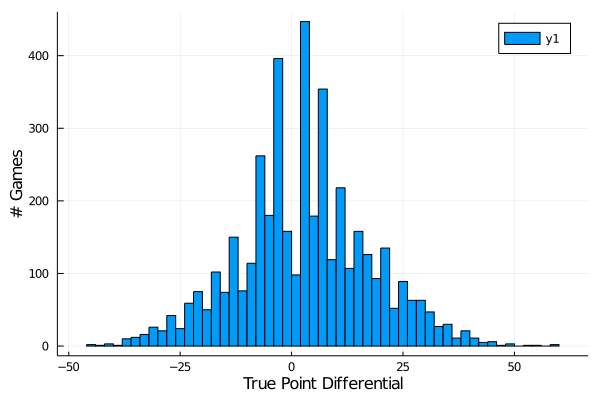

In [77]:
plot(predict_02_19[:PointDif], seriestype = :histogram, xlabel = "True Point Differential", ylabel = "# Games")

In [78]:
# season_data = DataFrame(teams[1])

#concatenate all game data
# final = DataFrame(teams[1])
# for i in 2:32
#     final = vcat(final, teams[i])
# end

In [79]:
# final
#function least_squares_reg(data, test_split, )

In [207]:
#regression on ppg
train_x_ppg = hcat(train[:HomePtsPG], train[:AwayPtsPG], ones(size(train)[1]))
train_y_ppg = train[:PointDif]
test_x_ppg = hcat(test[:HomePtsPG], test[:AwayPtsPG], ones(size(test)[1]))
test_y_ppg = test[:PointDif]
w_ppg = train_x_ppg \ train_y_ppg

3-element Array{Float64,1}:
  0.4060547972117269
 -0.39466560564881253
  2.343615135691181

PPG
Train MSE	208.23982536879552
Test MSE 	196.2567241327871
Train Winner Accuracy	0.6054992764109985
Test Winner Accuracy	0.6053240740740741


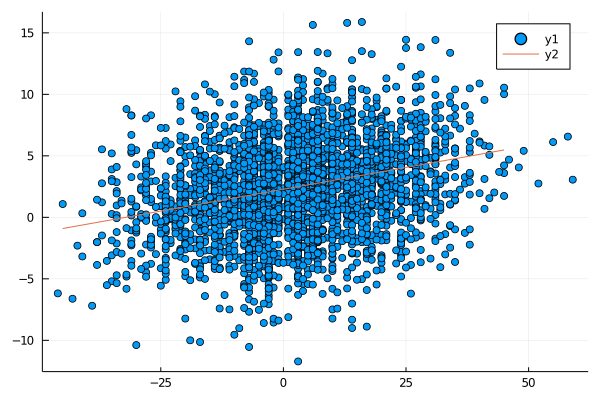

In [208]:
train_pred_ppg = train_x_ppg*w_ppg
test_pred_ppg = test_x_ppg*w_ppg

train_MSE = MSE(train_y_ppg, train_pred_ppg)
test_MSE = MSE(test_y_ppg, test_pred_ppg)

train_winner_acc = winner_acc(train_y_ppg, train_pred_ppg)
test_winner_acc = winner_acc(test_y_ppg, test_pred_ppg)

println("PPG")
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)
println("Train Winner Accuracy\t", train_winner_acc)
println("Test Winner Accuracy\t", test_winner_acc)

real_y = test_y_ppg
pred_y = test_pred_ppg

slope = hcat(real_y, ones(size(real_y)[1])) \ pred_y
f(x) = slope[1]*x + slope[2]

plot(train_y_ppg, train_pred_ppg, seriestype = :scatter)
xsamp = range(-45,45, step = 1)
plot!(xsamp, [f(x) for x in xsamp])

In [189]:
# #OLD regression on ppg
# train_x_ppg = hcat(train[:HomePtsPG], train[:AwayPtsPG], ones(size(train)[1]))
# train_y_ppg = train[:PointDif]
# test_x_ppg = hcat(test[:HomePtsPG], test[:AwayPtsPG], ones(size(test)[1]))
# test_y_ppg = test[:PointDif]
# w_ppg = train_x_ppg \ train_y_ppg

3-element Array{Float64,1}:
  0.49366942668697367
 -0.7266105528694375
  6.313435349127772

In [228]:
showall(train[1:10,:])

10×27 DataFrame
│ Row │ Year    │ Week    │ Home    │ Away    │ PointDif │ HomeWin% │ AwayWin% │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Float64  │ Float64  │ Float64  │
├─────┼─────────┼─────────┼─────────┼─────────┼──────────┼──────────┼──────────┤
│ 1   │ 2018.0  │ 6.0     │ 22.0    │ 14.0    │ 8.0      │ 0.25     │ 0.25     │
│ 2   │ 2018.0  │ 12.0    │ 4.0     │ 15.0    │ 3.0      │ 0.333333 │ 0.0      │
│ 3   │ 2019.0  │ 8.0     │ 6.0     │ 26.0    │ -1.0     │ 0.333333 │ 0.25     │
│ 4   │ 2003.0  │ 17.0    │ 27.0    │ 28.0    │ -7.0     │ 0.5      │ 0.5      │
│ 5   │ 2011.0  │ 5.0     │ 27.0    │ 30.0    │ 45.0     │ 0.75     │ 0.75     │
│ 6   │ 2006.0  │ 6.0     │ 2.0     │ 21.0    │ -13.0    │ 0.666667 │ 0.666667 │
│ 7   │ 2005.0  │ 6.0     │ 11.0    │ 5.0     │ -1.0     │ 0.333333 │ 0.75     │
│ 8   │ 2003.0  │ 8.0     │ 19.0    │ 8.0     │ 6.0      │ 0.75     │ 0.5      │
│ 9   │ 2005.0  │ 11.0    │ 12.0    │ 18.0    │ -3.0     │ 0.25     │ 0.75     │
│ 10  │ 2015

In [253]:
train_x_sparse = hcat(train[:HomePtsPG], train[:AwayPtsPG], train[:HomePtsAllowedPG], train[:HomeRushAllowedPG], train[:HomePassAllowedPG], ones(size(train)[1])) 
train_y_sparse = train[:PointDif]
test_x_sparse = hcat(test[:HomePtsPG], test[:AwayPtsPG], test[:HomePtsAllowedPG], test[:HomeRushAllowedPG], test[:HomePassAllowedPG], ones(size(test)[1])) 
test_y_sparse = test[:PointDif]
w_sparse = train_x_sparse \ train_y_sparse

6-element Array{Float64,1}:
  0.37164346597267034
 -0.39789053163305144
 -0.28823956247537696
 -0.015198746634676068
 -0.00122607921683475
 11.554912210082508

In [254]:
n = len = length(train_y_sparse)
ybool = sign.(train_y_sparse).>=0 # form a boolean target

# we form \frac 1 n \sum_{i=1}^n (1 - ⋅ )_+ by multiplying the HingeLos
h_loss = 1/n*HingeLoss()
l_loss = 1/n*LogisticLoss()

# we form λ|| ⋅ ||^2 by multiplying the QuadReg() function by λ 
λ=1
reg = λ*QuadReg()
# minimize 1/n \frac 1 n \sum_{i=1}^n (1 - y_i w^T x_i)_+ + λ||w||^2
w_hinge =proxgrad(h_loss, reg, train_x_sparse, ybool, maxiters=100)
w_logst=proxgrad(l_loss, reg, train_x_sparse, ybool, maxiters=100)

6-element Array{Float64,1}:
  0.0038881212316996213
 -0.0017555635621054376
 -0.0011542443349482907
 -0.002478766073795742
  0.002253354565034933
  5.6557405451736456e-5

In [255]:
n_test = length(test_y_sparse)
ybool_test = sign.(test_y_sparse).>=0;

In [256]:
y_h_hat = impute(h_loss, test_x_sparse*w_hinge)
h_err = (n_test - sum(y_h_hat .== ybool_test)) / n_test
println("Misclassification rate of w_hinge: ", h_err)

Misclassification rate of w_hinge: 0.42824074074074076


In [257]:
y_l_hat = impute(l_loss, test_x_sparse*w_logst)
l_err = (n_test - sum(y_l_hat .== ybool_test)) / n_test
println("Misclassification rate of w_logistic: ", l_err)

Misclassification rate of w_logistic: 0.4351851851851852


In [224]:
#regression on ppg and takeaways
train_x_small = hcat(train[:HomePtsPG], train[:AwayPtsPG], train[:HomeTakeawaysPG], train[:AwayTakeawaysPG], ones(size(train)[1]))
train_y_small = train[:PointDif]
test_x_small = hcat(test[:HomePtsPG], test[:AwayPtsPG], test[:HomeTakeawaysPG], test[:AwayTakeawaysPG], ones(size(test)[1]))
test_y_small = test[:PointDif]
w_small = train_x_small \ train_y_small

5-element Array{Float64,1}:
  0.4039101239542921
 -0.40203902003593234
  0.07623697003704671
  0.17944707993848674
  2.1441470925215107

PPG and Takeaways
Train MSE	208.21530632017252
Test MSE 	196.14066328535952
Train Winner Accuracy	0.604630969609262
Test Winner Accuracy	0.6076388888888888


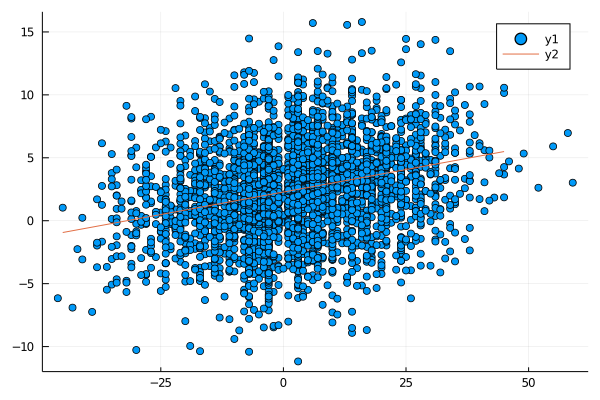

In [225]:
train_pred_small = train_x_small*w_small
test_pred_small = test_x_small*w_small

train_MSE = MSE(train_y_small, train_pred_small)
test_MSE = MSE(test_y_small, test_pred_small)

train_winner_acc = winner_acc(train_y_small, train_pred_small)
test_winner_acc = winner_acc(test_y_small, test_pred_small)

println("PPG and Takeaways")
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)
println("Train Winner Accuracy\t", train_winner_acc)
println("Test Winner Accuracy\t", test_winner_acc)


real_y = test_y_small
pred_y = test_pred_small

slope = hcat(real_y, ones(size(real_y)[1])) \ pred_y
f(x) = slope[1]*x + slope[2]

plot(train_y_small, train_pred_small, seriestype = :scatter)
xsamp = range(-45,45, step = 1)
plot!(xsamp, [f(x) for x in xsamp])

In [214]:
#regression on all columns
train_x_vals = convert(Matrix, train[:,6:end])
train_x = hcat(train_x_vals, ones(size(train)[1]))
train_y = train[:PointDif]

test_x_vals = convert(Matrix, test[:,6:end])
test_x = hcat(test_x_vals, ones(size(test)[1]))
test_y = test[:PointDif]

w = train_x \ train_y

23-element Array{Float64,1}:
  4.227866521507237
 -1.7311408940278248
  0.12479627133921119
  0.2952221279585908
 -0.005456154183210844
  0.01286475391613619
 -0.08128041452839378
 -0.26083213157430774
  0.2475638608172635
 -0.022382389963632305
 -0.010069921265028947
 -0.5079692560074973
 -0.24453887816964223
 -0.16342372512714645
 -0.0015379058162021326
 -0.009231487981923256
  0.24831641165805787
  0.1786127642074702
 -0.162446729550143
  0.016828241479028942
  0.006121756766506178
  0.5886913975313819
  2.8062577738261054

Full
Train MSE	199.08255511640408
Test MSE 	191.50450388192493
Train Winner Accuracy	0.6335745296671491
Train Winner Accuracy	0.6180555555555556


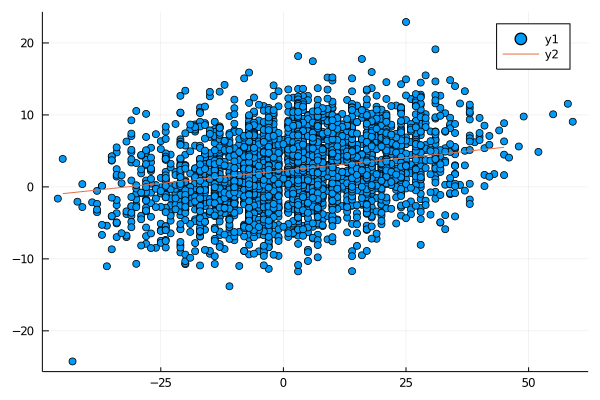

In [215]:
train_pred_full = train_x*w
test_pred_full = test_x*w

train_MSE = MSE(train_y, train_pred_full)
test_MSE = MSE(test_y, test_pred_full)

train_winner_acc = winner_acc(train_y, train_pred_full)
test_winner_acc = winner_acc(test_y, test_pred_full)

println("Full")
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)
println("Train Winner Accuracy\t", train_winner_acc)
println("Train Winner Accuracy\t", test_winner_acc)


real_y = test_y_small
pred_y = test_pred_small

slope = hcat(real_y, ones(size(real_y)[1])) \ pred_y
f(x) = slope[1]*x + slope[2]

plot(train_y, train_pred_full, seriestype = :scatter)
xsamp = range(-45,45, step = 1)
plot!(xsamp, [f(x) for x in xsamp])



In [178]:
# slope = hcat(train_y, ones(200)) \ train_pred_ppg
# f(x) = slope[1]*x + slope[2]
# f2(x) = x

PPG and Takeaways
Train MSE	184.09764748070856
Test MSE 	183.874503597864
Train Winner Accuracy	0.6145833333333334
Test Winner Accuracy	0.5416666666666666


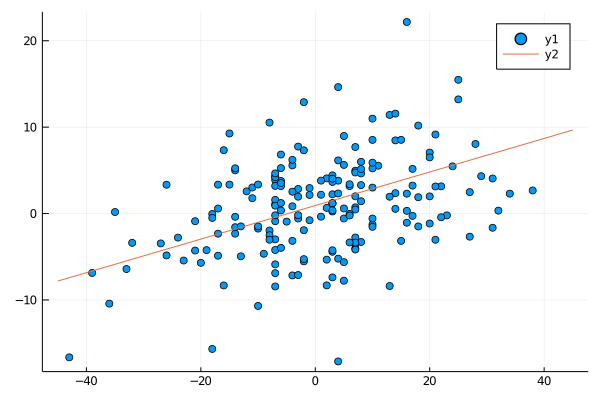

In [194]:
train_pred_small = train_x_small*w_small
test_pred_small = test_x_small*w_small

train_MSE = MSE(train_y, train_pred_small)
test_MSE = MSE(test_y, test_pred_small)

train_winner_acc = winner_acc(train_y, train_pred_small)
test_winner_acc = winner_acc(test_y, test_pred_small)

println("PPG and Takeaways")
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)
println("Train Winner Accuracy\t", train_winner_acc)
println("Test Winner Accuracy\t", test_winner_acc)

plot(train_y, train_pred_small, seriestype = :scatter)
xsamp = range(-45,45, step = 1)
plot!(xsamp, [f(x) for x in xsamp])

Full
Train MSE	159.3027638230459
Test MSE 	195.69387931651815
Train Winner Accuracy	0.6822916666666666
Train Winner Accuracy	0.5625


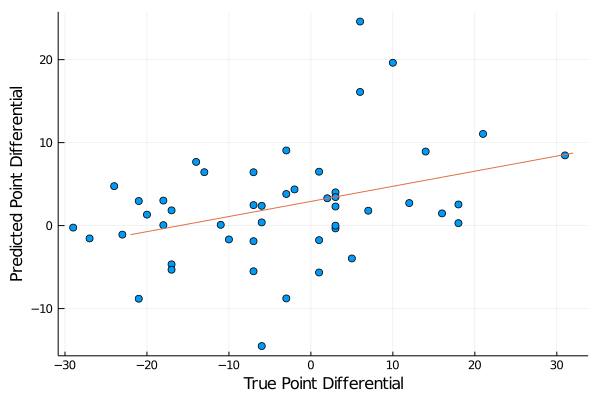

In [195]:
train_pred_full = train_x*w
test_pred_full = test_x*w

train_MSE = MSE(train_y, train_pred_full)
test_MSE = MSE(test_y, test_pred_full)

train_winner_acc = winner_acc(train_y, train_pred_full)
test_winner_acc = winner_acc(test_y, test_pred_full)

println("Full")
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)
println("Train Winner Accuracy\t", train_winner_acc)
println("Train Winner Accuracy\t", test_winner_acc)

# plot(train_y, train_pred_full, seriestype = :scatter)
real = test_y
pred = test_pred_full
plot(real, pred, seriestype = :scatter, xlabel = "True Point Differential", ylabel = "Predicted Point Differential")
slope = hcat(real, ones(size(real)[1])) \ pred
f(x) = slope[1]*x + slope[2]
xsamp = range(-22,32, step = 1)
plot!(xsamp, [f(x) for x in xsamp], legend = false)




In [89]:
# train_winner = sign.(train[:PointDif])
# test_winner = sign.(test[:PointDif])
# train_pred_winner = sign.(train_pred_full)
# test_pred_winner = sign.(test_pred_full)

# train_acc = max.(sign.(train_winner.*train_pred_winner),0)
# test_acc = max.(sign.(test_winner.*test_pred_winner),0)

# tr = mean(train_acc)
# te = mean(test_acc)
# println("Train accuracy: $tr")
# println("Test accuracy: $te")

Train accuracy: 0.645
Test accuracy: 0.55


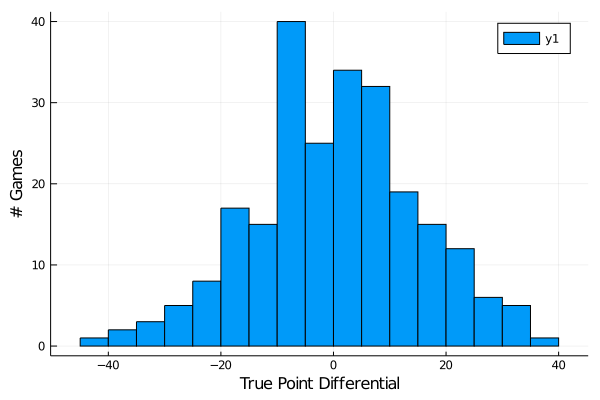

In [196]:
plot(predict[:PointDif], seriestype = :histogram, xlabel = "True Point Differential",
    ylabel = "# Games")

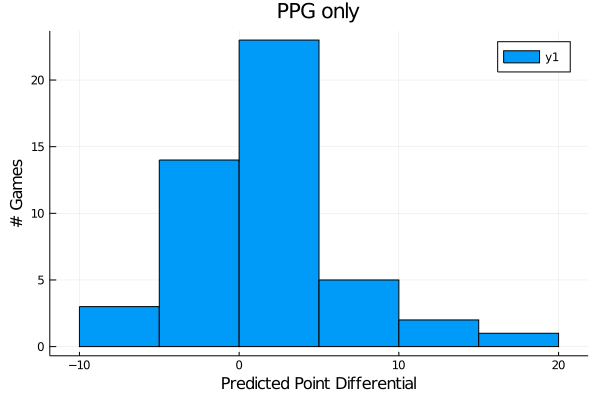

In [200]:
plot(test_pred_ppg, seriestype = :histogram, title = "PPG only", 
    xlabel = "Predicted Point Differential", ylabel = "# Games")

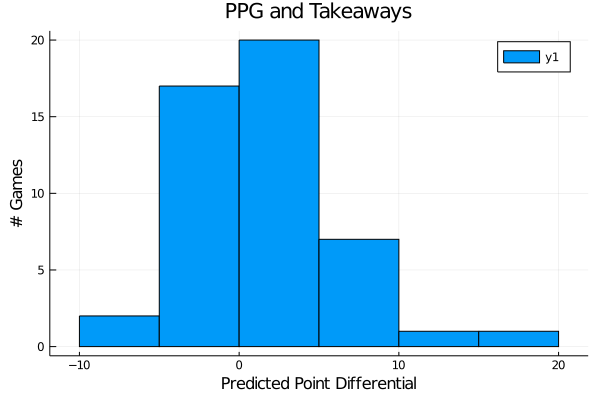

In [201]:
plot(test_pred_small, seriestype = :histogram, title = "PPG and Takeaways", 
    xlabel = "Predicted Point Differential", ylabel = "# Games")

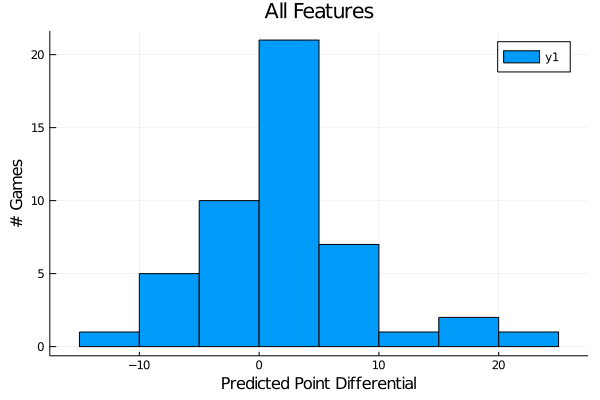

In [202]:
plot(test_pred_full, seriestype = :histogram, title = "All Features", 
    xlabel = "Predicted Point Differential", ylabel = "# Games")

In [131]:
#testing regressions on a late week, low point dif game
n = 28
n = 20
test_game = convert(Array,test[n,5:end])
X_game = append!(test_game, 1)
X_game_ppg = [test[n,:HomePtsPG] test[n,:AwayPtsPG] 1]
X_game_small = [X_game_ppg[1:2]' test[n,:HomeTakeawaysPG] test[n,:AwayTakeawaysPG] 1]

actual = test[n,:PointDif]
pred_ppg_arr = X_game_ppg*w_ppg #this comes out as an array for some reason
pred_ppg = pred_ppg_arr[1]
pred_small = X_game_small*w_small
pred = X_game'*w

println("Actual: $actual")
println("PPG: $pred_ppg")
println("Small: $pred_small")
println("Full: $pred")

Actual: 4.0
PPG: -12.008662367892825
Small: -19.808479182003886
Full: -25.22836258149147


In [119]:
vegas = CSV.read("example.csv", skipto = 4, limit = 10)

,Week,Day,Date,Rec,isHome,Team,Opponent,Tm,Opp_1
,Int64,String,String,Date…,Int64,Int64,Int64,Int64,Int64
1,3,Sun,September 22,0000-02-01,1,1,5,20,38
2,4,Sun,September 29,0000-03-01,1,1,28,10,27
3,5,Sun,October 6,0001-03-01,0,1,7,26,23
4,6,Sun,October 13,0002-03-01,1,1,2,34,33
5,7,Sun,October 20,0003-03-01,0,1,21,27,21
6,8,Sun,October 27,0003-04-01,0,1,20,9,31
7,9,Thu,October 31,0003-05-01,1,1,27,25,28
8,10,Sun,November 10,0003-06-01,0,1,30,27,30
9,11,Sun,November 17,0003-07-01,0,1,27,26,36


In [44]:
hTeam = "Bills"
aTeam = "Seahawks"
h_2020_ppg = 24.8
h_2020_ta = 10/8
a_2020_ppg = 34.3
a_2020_ta = 14/7
X = [h_2020_ppg a_2020_ppg h_2020_ta a_2020_ta 1]
pd = X*w
print("The $hTeam will outscore the $aTeam by $pd points.")

The Bills will outscore the Seahawks by [-6.664648729333212] points.

In [374]:
hTeam = "Jets"
aTeam = "Patriots"
h_2020_ppg = 11.8
a_2020_ppg = 19.4
X = [h_2020_ppg a_2020_ppg 1]
pd = X*w
print("The $hTeam will outscore the $aTeam by $pd points.")

The Jets will outscore the Patriots by [-3.6037246779832084] points.